In [1]:
import time
# import IPython
import os
import json
from datetime import datetime
import pyswarm
import pandas

import joblib
import numpy as np
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
from tensorflow import keras
import tensorflow.keras.backend as K
from pyswarm import pso


from keras.models import Sequential, Model
# from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Lambda, Layer
# from tensorflow.keras import losses
# from keras.utils.vis_utils import plot_model, model_to_dot

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sklearn.preprocessing

# from sklearn.model_selection import train_test_split
# from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error

K.set_floatx('float32')

tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels

tf.enable_v2_behavior()

from tester.tester import Tester

import random

2022-02-25 18:42:47.811285: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-25 18:42:47.811321: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
lb = [2.2, 1.08, -40.]  # lower bounds of the design variables, i.e. input params for the sut_model
ub = [2.8, 1.41, 175.] 
# log_path = os.path.join('.','2022_02_24_17_12_27_inf_gain')
# log_path = os.path.join('.','2022_02_24_19_52_58_inf_gain')
log_path = os.path.join('.','inf_gain'+str(5))

log_path

'./inf_gain5'

In [3]:
path = os.path.join(log_path, 'run_stats.txt')
with open(path, 'r') as file:
    run_stats = json.load(file)    

    
num_samples = run_stats['num_samples']
training_proportion = run_stats['training_proportion']
optimization_proportion = 1. - training_proportion

log_std_coefficient = run_stats['log_std_coefficient']
constant_std_coefficient = run_stats['constant_std_coefficient']

run_stats

{'num_samples': 100,
 'training_proportion': 0.25,
 'log_std_coefficient': 4.0,
 'constant_std_coefficient': 10.0}

In [4]:
path = os.path.join(log_path, 'training.npyz')
with open(path, 'rb') as file:
    training_data = np.load(file)
    training_Xs=training_data['points']
    training_ys=training_data['values']
    norm_training_Xs=training_data['norm_points']
    norm_training_ys=training_data['norm_values']
    lls_=training_data['loss']
    amplitude= training_data['amplitude']
    relevances= training_data['relevances']
    noise_var= training_data['noise']
    

In [5]:
path=os.path.join(log_path,'scaler_X.pkl')
transform_X = joblib.load(path)
path=os.path.join(log_path,'scaler_y.pkl')
transform_y = joblib.load(path)


norm_ub = transform_X.transform([ub])[0].astype(np.float32)
norm_lb = transform_X.transform([lb])[0].astype(np.float32)

/home/llarrauriborroto/Documents/Projects/advanced-bayesian-opt/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.preprocessing.data module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/llarrauriborroto/Documents/Projects/advanced-bayesian-opt/lib/python3.8/site-packages/sklearn/base.py:313: UserWarning: Trying to unpickle estimator StandardScaler from version 0.21.2 when using version 0.22. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [6]:
norm_training_Xs


array([[ 1.2739575 ,  0.83355457, -0.6578885 ],
       [-0.6780739 ,  0.83355457, -0.47638273],
       [ 0.5034193 ,  0.83355457, -1.034862  ],
       [-1.8081977 ,  0.83355457,  1.4084845 ],
       [-0.26712015, -0.55570275,  1.1990548 ],
       [-1.8081977 , -0.55570275, -0.47638273],
       [ 0.09246434,  1.2676971 ,  0.64057565],
       [ 0.09246434,  1.2676971 ,  1.4084845 ],
       [ 1.2739575 ,  0.83355457,  1.4084845 ],
       [-1.0376596 ,  0.4862405 ,  0.64057565],
       [ 0.5034193 , -1.2503319 , -1.3141016 ],
       [ 1.2739575 ,  1.2676971 , -0.19714315],
       [ 0.5034193 , -1.5976459 , -0.6578885 ],
       [ 0.86300373,  1.2676971 , -0.19714315],
       [-0.26712015, -0.20838864,  1.1990548 ],
       [-1.0376596 , -1.5976459 , -1.5933412 ],
       [ 0.86300373, -0.20838864,  1.1990548 ],
       [-1.8081977 , -1.5976459 , -1.3141016 ],
       [ 0.09246434, -0.20838864, -0.47638273],
       [ 1.2739575 , -1.2503319 ,  0.36133602],
       [-1.4486132 , -0.9030178 ,  0.919

In [7]:
kernel = tfk.ExponentiatedQuadratic(amplitude, length_scale=1.0)
kernel = tfk.FeatureScaled(kernel, scale_diag=relevances)
gp_model = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=[[1.2353002 , -0.7703848 ,  1.1779659]],
    observation_index_points=norm_training_Xs,
    observations=norm_training_ys,
    observation_noise_variance=noise_var,
    predictive_noise_variance=0.,
    jitter=1e-4)

gp_model.mean()

2022-02-25 18:42:50.361907: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-02-25 18:42:50.361946: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-25 18:42:50.361975: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (t460slalb): /proc/driver/nvidia/version does not exist
2022-02-25 18:42:50.362376: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<tf.Tensor: shape=(), dtype=float32, numpy=-1.6895943>

In [8]:
path = os.path.join(log_path, 'optimization_rounds.npyz')
with open(path, 'rb') as file:
    optimization_data = np.load(file)
    real_values=optimization_data['values']
    real_choices=optimization_data['choices']
    mean_regrets=optimization_data['mean_regrets']


In [9]:
values= transform_y.transform(real_values.reshape(-1,1))
choices= np.array(transform_X.transform(real_choices), dtype=np.float32)
values=np.array(values.flatten(),dtype=np.float32)


In [10]:
filepath = os.path.join(log_path, 'validation.npyz')


with open(filepath, 'rb') as file:
    data = np.load(file)
    valid_real_Xs=data['points']
    valid_real_ys=data['values']


In [11]:
valid_norm_Xs=np.array(transform_X.transform(valid_real_Xs),dtype=np.float32)
valid_norm_Xs
print(valid_real_ys)

[1.1364679 1.1364533 1.1364809 1.1364826 1.1364546 1.136453  1.1364746
 1.1364664 1.1364375 1.1366072 1.1366217 1.1366186 1.1366061 1.1365982
 1.1366205 1.1366148 1.1366053 1.1367441 1.1367519 1.136754  1.1367435
 1.1367403 1.1367362 1.1367514 1.1367447 1.1367383 1.136869  1.1368902
 1.1368879 1.1368802 1.1368752 1.1368766 1.1368825 1.1368804 1.1368675
 1.1369122 1.1369243 1.1369307 1.1369225 1.1369193 1.1369181 1.1369164
 1.1369104 1.1369476 1.1369559 1.1369513 1.136933  1.1369461 1.1369497
 1.1369456 1.1369486 1.1369312 1.1369246 1.1369195 1.1369295 1.1369048
 1.1369209 1.1369205 1.1369218 1.1369188 1.1368982 1.1368333 1.1368339
 1.1368332 1.1368451 1.1368332 1.1368301 1.1368381 1.1368384 1.1368365
 1.1366992 1.136702  1.1366899 1.136702  1.1366932 1.1366885 1.1366879
 1.1366869 1.1366874 1.1364846 1.1365002 1.1364875 1.1364605 1.1364737
 1.1364778 1.1364824 1.1364878 1.1364766 1.1361785 1.1362098 1.1361988
 1.13617   1.1361839 1.1361667 1.1361966 1.1361775 1.1361974 1.1358706
 1.135

In [12]:
opt_norm_Xs=norm_training_Xs.tolist()
opt_norm_ys=norm_training_ys.tolist()


In [13]:

print(len(norm_training_Xs.tolist()))
print(len(opt_norm_Xs))
print(len(opt_norm_ys))
print(len(choices))
print(len(values))


25
25
25
75
75


In [14]:
max_sample=[]
errs=[]
smerrs=[]
total_errs=[]

pred_points=[]
pred_vals=[]

for i in range((len(choices))+1):

    if i>0:
        opt_norm_Xs.append(choices[i-1])
        opt_norm_ys.append(values[i-1])

    gp_model = tfd.GaussianProcessRegressionModel(
        kernel=kernel,
        index_points=valid_norm_Xs,
        observation_index_points=opt_norm_Xs,
        observations=opt_norm_ys,
        observation_noise_variance=noise_var,
        predictive_noise_variance=0.,
        jitter=1e-4)
    pred_norm_ys = gp_model.mean().numpy()
    pred_real_ys = transform_y.inverse_transform(pred_norm_ys.reshape(-1,1)).flatten()

    valid_errs = pred_real_ys - valid_real_ys
    total_errs.append(valid_errs)
    errs.append(np.amax(valid_errs))
    sqvalid_errs = np.square(valid_errs)
    smerrs.append(np.sqrt(np.mean(sqvalid_errs)))
    max_sample.append(transform_y.inverse_transform(np.array([max(opt_norm_ys)])))
    
    # Predicted Maximum
    
#     if (i+1)%9== 0:
#         @tf.function(autograph=False, experimental_compile=False)
#         def eval_model(x):
#             gp_model = tfd.GaussianProcessRegressionModel(
#                 kernel=kernel,
#                 index_points=[x],
#                 observation_index_points=opt_norm_Xs,
#                 observations=opt_norm_ys,
#                 observation_noise_variance=noise_var,
#                 predictive_noise_variance=0.,
#                 jitter=1e-4)   
            
#             return gp_model.mean()
        
#         pred_point, pred_value = pso(func=lambda x: -eval_model(np.float32(x)), lb=norm_lb, ub=norm_ub, maxiter=50,
#                             debug=False)
#         norm_point = transform_X.inverse_transform([pred_point])[0].astype(np.float32)
#         norm_val = transform_y.inverse_transform([-pred_value])[0].astype(np.float32)
        
#         pred_points.append(norm_point)
#         pred_vals.append(norm_val)
        
    ##
    
max_sample=np.array(max_sample)
max_sample=max_sample.flatten()



In [15]:


# filepath = os.path.join('.', 'predicted_optimums90.npyz')
# to_save = {
#     'values': pred_vals,
#     'choices': pred_points,
# }

# with open(filepath, 'wb') as file:
#     np.savez(file, **to_save)
    
    
# with open(filepath, 'rb') as file:
#     data = np.load(file)
#     print(data['choices'])
#     print(data['values'])

    

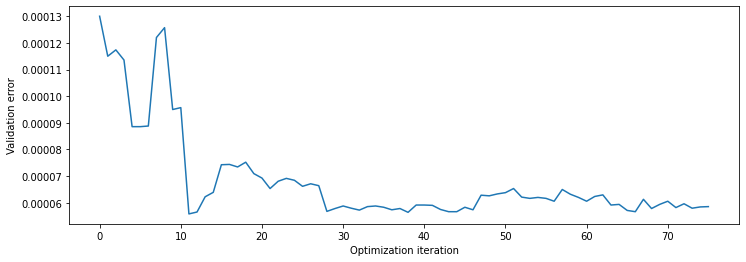

In [16]:
plt.figure(figsize=(12, 4))
plt.plot(errs)
plt.xlabel("Optimization iteration")
plt.ylabel("Validation error")
# path = os.path.join(log_path, 'mean_regrets.png')
# plt.savefig(path)
# plt.show()
plt.savefig('max_loss.pdf',format='pdf',dpi=1200)

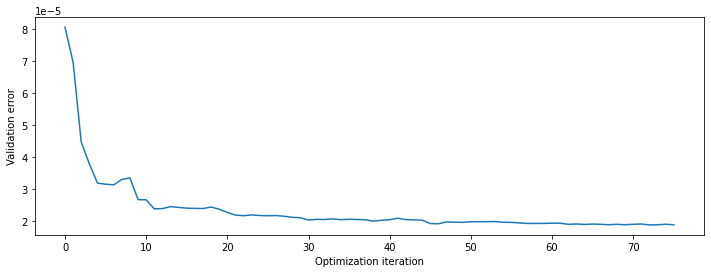

In [17]:
plt.figure(figsize=(12, 4))
plt.plot(smerrs)
plt.xlabel("Optimization iteration")
plt.ylabel("Validation error")
# path = os.path.join(log_path, 'mean_regrets.png')
# plt.savefig(path)
# plt.show()
plt.savefig('sme.pdf',format='pdf',dpi=1200)

array([1.1369127 , 1.1369127 , 1.1369127 , 1.1369127 , 1.1369127 ,
       1.1369127 , 1.1369127 , 1.1369127 , 1.1369127 , 1.1369127 ,
       1.1369127 , 1.1369127 , 1.1369127 , 1.1369127 , 1.1369127 ,
       1.1369127 , 1.1369127 , 1.1369127 , 1.1369127 , 1.1369127 ,
       1.1369127 , 1.1369127 , 1.1369127 , 1.1369127 , 1.1369127 ,
       1.1369127 , 1.1369127 , 1.1369127 , 1.1369127 , 1.1369127 ,
       1.1369127 , 1.1369127 , 1.1369127 , 1.1369127 , 1.1369127 ,
       1.1369127 , 1.1369127 , 1.1369127 , 1.1369127 , 1.1369127 ,
       1.1369127 , 1.1369127 , 1.1369127 , 1.1369127 , 1.1369127 ,
       1.1369127 , 1.13694882, 1.13694882, 1.13694882, 1.13694882,
       1.13694882, 1.13694882, 1.13694882, 1.13694882, 1.13694882,
       1.13694882, 1.13694882, 1.13694882, 1.13694882, 1.13694882,
       1.13694882, 1.13694882, 1.13694882, 1.13694882, 1.13694882,
       1.13694882, 1.13694882, 1.13694882, 1.13694882, 1.13694882,
       1.13694882, 1.13694882, 1.13694882, 1.13694882, 1.13694

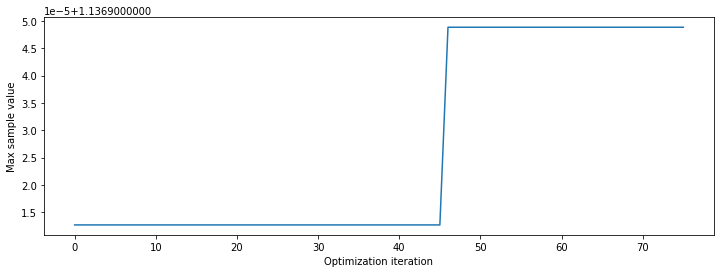

In [18]:
plt.figure(figsize=(12, 4))
plt.plot(max_sample)
plt.xlabel("Optimization iteration")
plt.ylabel("Max sample value")
# path = os.path.join(log_path, 'mean_regrets.png')
# plt.savefig(path)
# plt.show()
plt.savefig('max.pdf',format='pdf',dpi=1200)
max_sample